In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from pandas import read_csv

In [ ]:
data = pd.read_csv('seoul.csv')

In [ ]:
data.head()

,hour,taxi_count,day_of_week
0,2018-01-01 00:00:00,83070,0
1,2018-01-01 01:00:00,91454,0
2,2018-01-01 02:00:00,80141,0
3,2018-01-01 03:00:00,66395,0
4,2018-01-01 04:00:00,57897,0


In [ ]:
data['hour'] = pd.to_datetime(data['hour'])
data.set_index('hour', inplace=True)

In [ ]:
data.head()

,taxi_count,day_of_week
hour,,
2018-01-01 00:00:00,83070,0
2018-01-01 01:00:00,91454,0
2018-01-01 02:00:00,80141,0
2018-01-01 03:00:00,66395,0
2018-01-01 04:00:00,57897,0


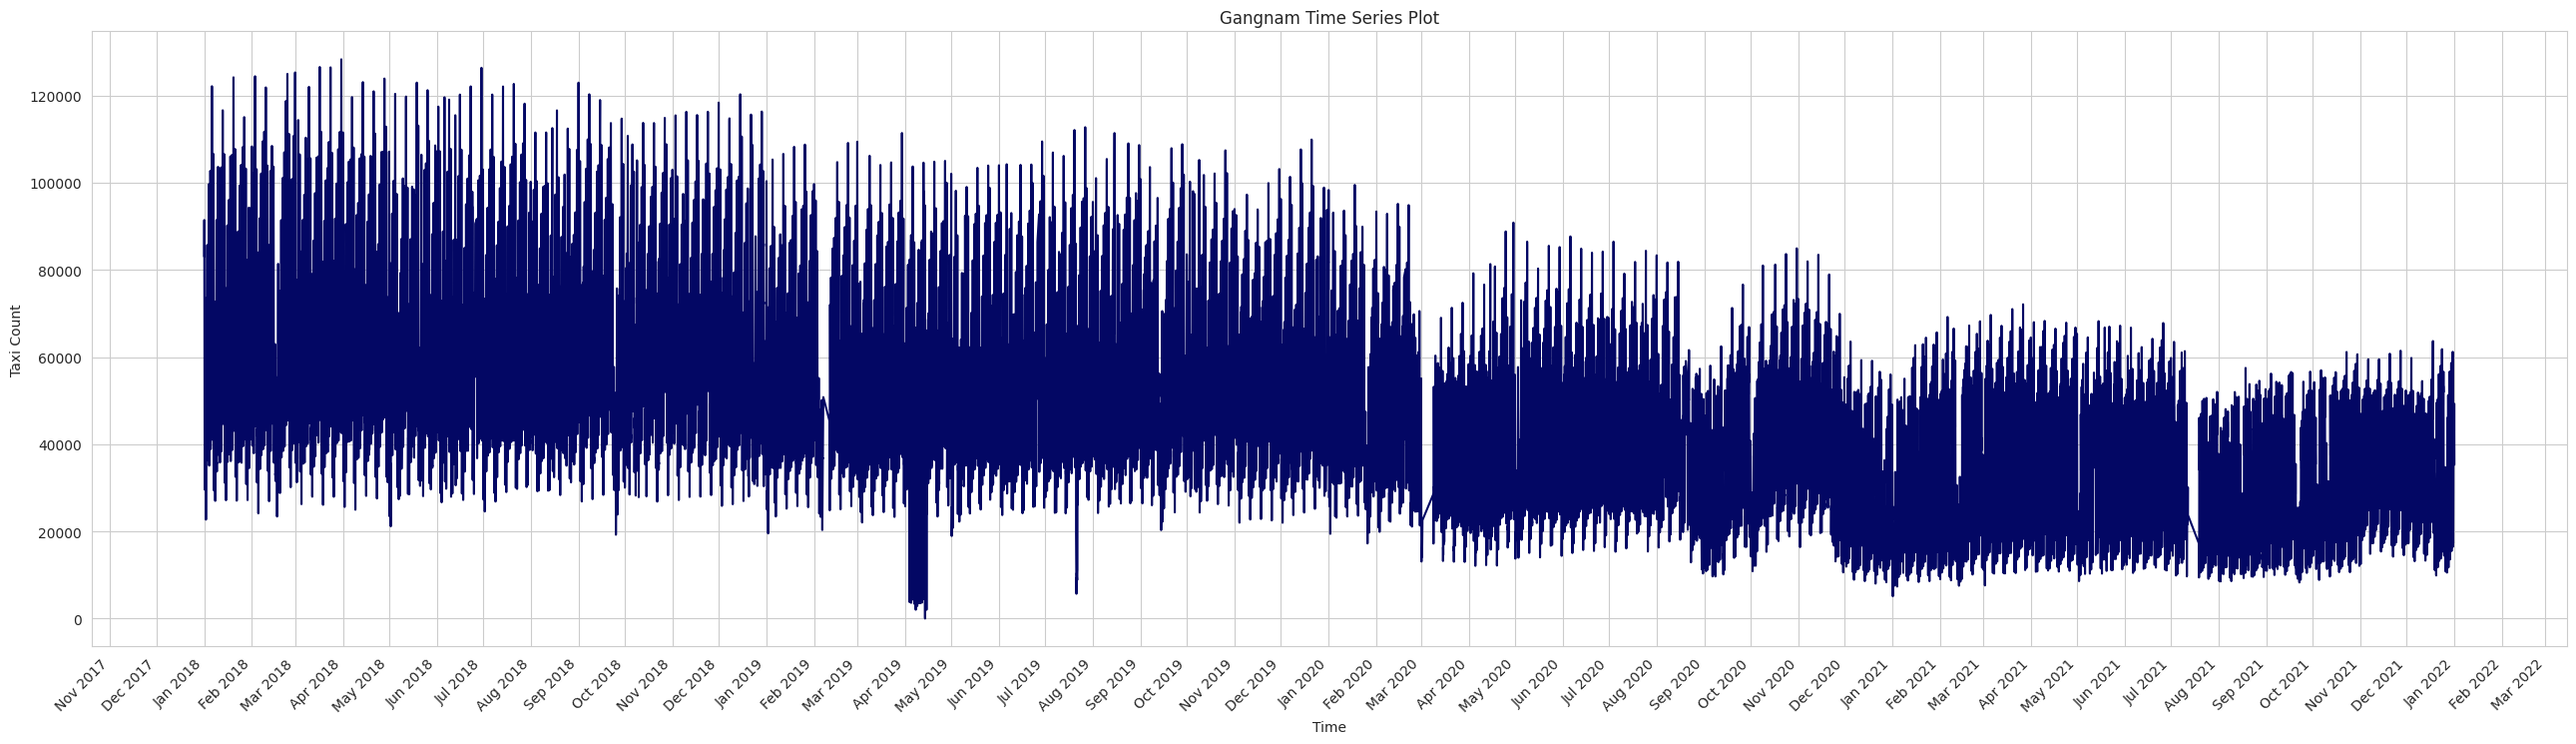

In [ ]:
# Set seaborn style to whitegrid
sns.set_style('whitegrid')

# Plotting the time series data
fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(data.index, data['taxi_count'], color='#030764')

# Formatting the x-axis to display monthly labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')


# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Taxi Count')
plt.title('Gangnam Time Series Plot')

# Displaying the plot
plt.show()

Stationary Data

In [ ]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(data['taxi_count'])

In [ ]:
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.267362
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
#data = df.diff(23).dropna()

Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

data['taxi_count'] = data['taxi_count'].astype(np.float64)
#data['day_of_week'] = data['day_of_week'].astype(np.float64)


# Normalize the  data (center around 0 and scale to remove the variance).
scaler1 = StandardScaler()
data['taxi_count'] = scaler1.fit_transform(data['taxi_count'].values.reshape(-1, 1))

scaler2 = StandardScaler()
data['day_of_week'] = scaler2.fit_transform(data['day_of_week'].values.reshape(-1, 1))

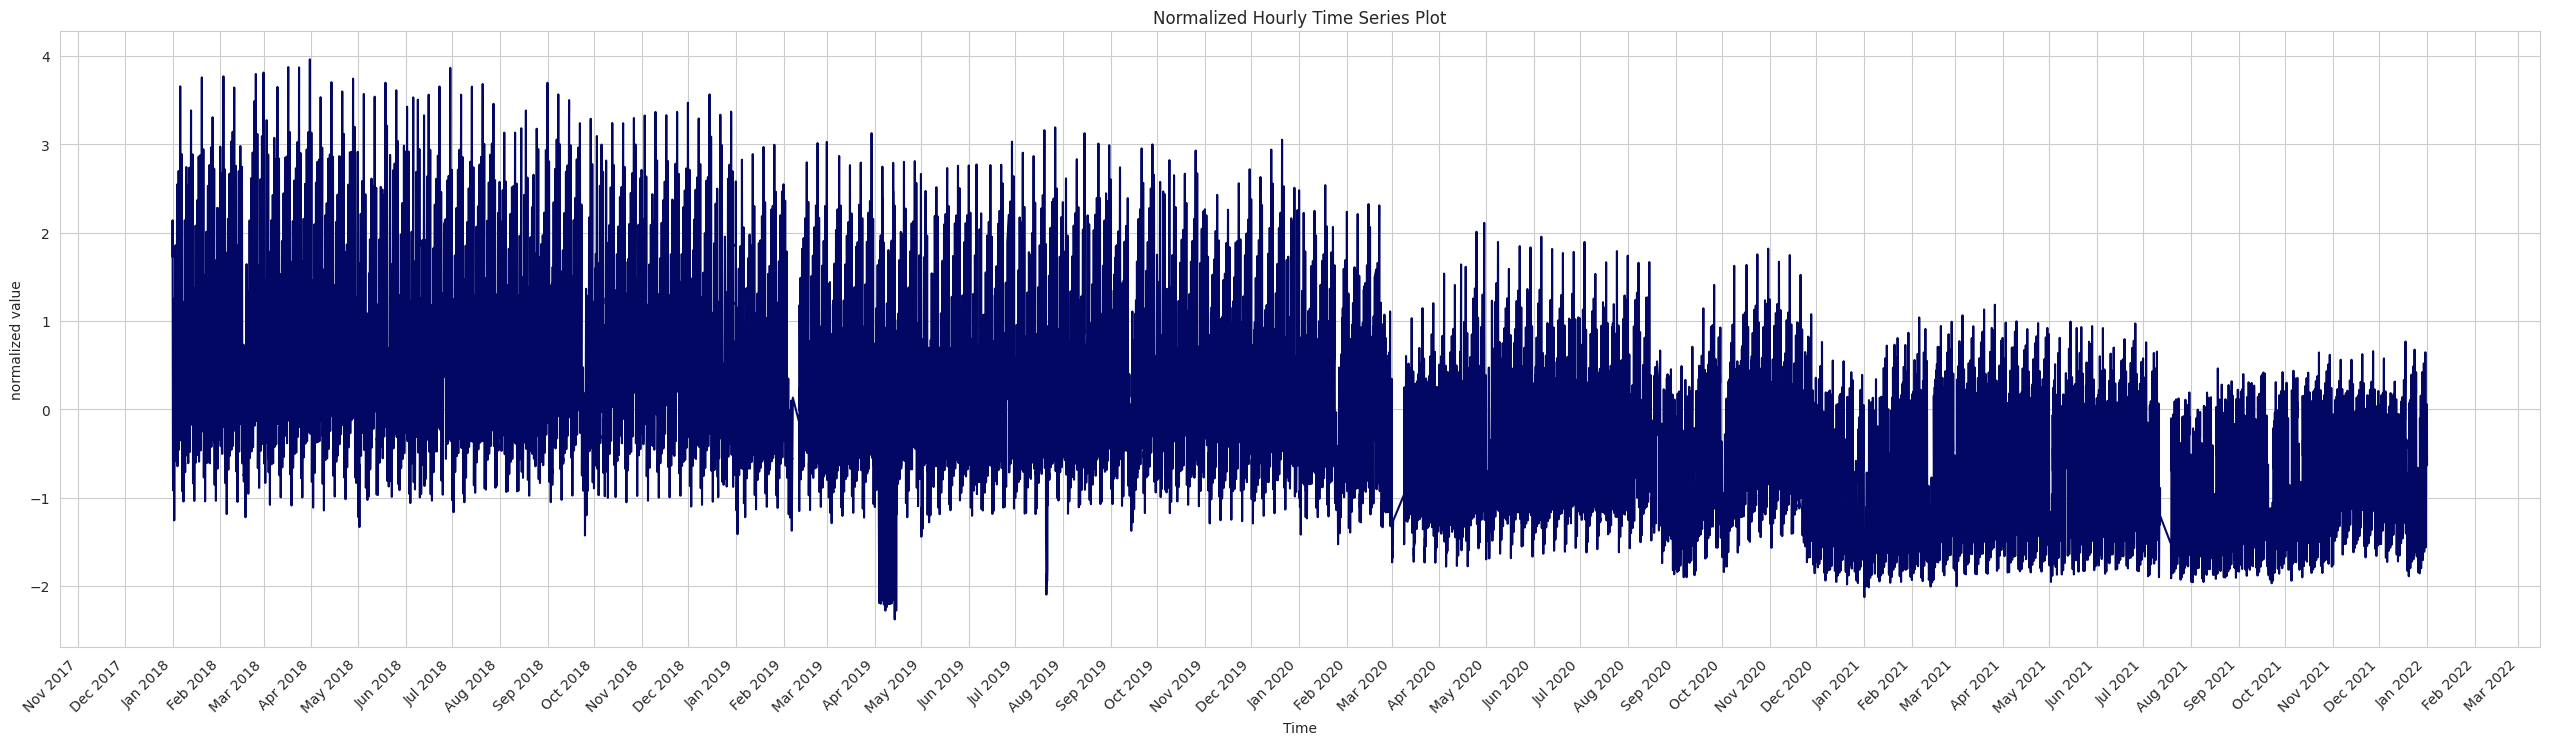

In [ ]:
# Set seaborn style to whitegrid
sns.set_style('whitegrid')

# Plotting the time series data
fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(data.index, data['taxi_count'], color='#030764')

# Formatting the x-axis to display monthly labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')


# Adding labels and title
plt.xlabel('Time')
plt.ylabel('normalized value')
plt.title('Normalized Hourly Time Series Plot')

# Displaying the plot
plt.show()

Create the training, validation and test sets

In [ ]:
taxi_train = data['2018-01-01':'2019-04-30'][['taxi_count', 'day_of_week']].values # 2019
taxi_valid = data['2019-05-01':'2019-12-31'][['taxi_count', 'day_of_week']].values #2019
taxi_test = data['2021-01-01':'2021-12-31'][['taxi_count', 'day_of_week']].values # 2020, 2021, 2022

In [ ]:
window_length = 23

In [ ]:
train_windows = []

for window_start in range(0, len(taxi_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(taxi_train[window_range])
    train_windows.append(window)

In [ ]:
len(train_windows)


11494

In [ ]:
# shape of training set
x_train = np.array(train_windows)
x_train.shape

(11494, 23, 2)

In [ ]:
y_train = np.array(train_windows)
y_train = y_train[:, :, 0].reshape(-1, x_train.shape[1], 1)

In [ ]:
y_train.shape

(11494, 23, 1)

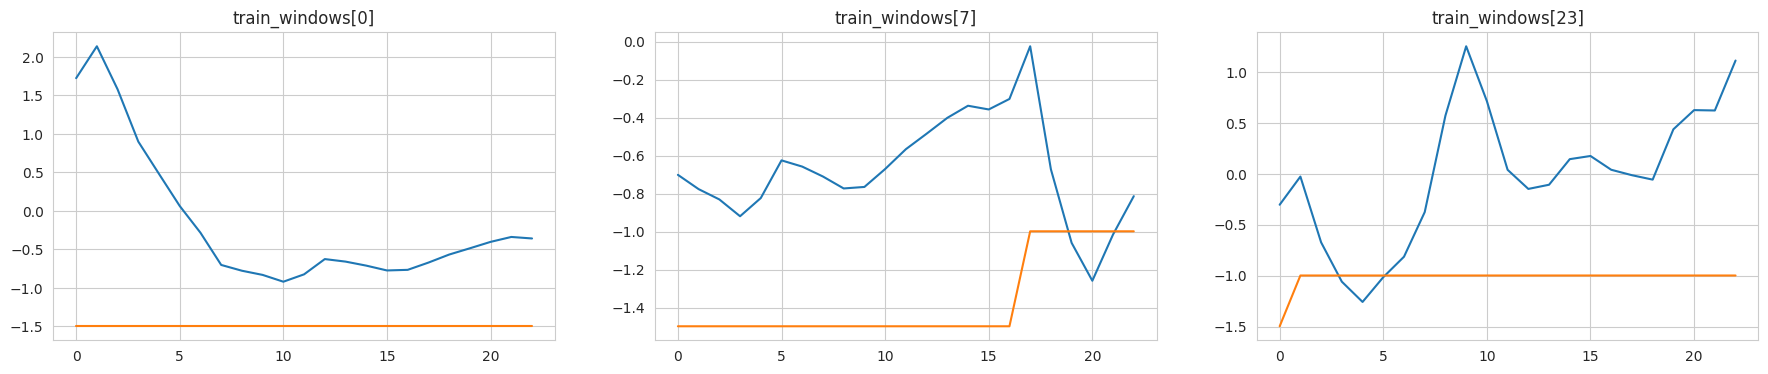

In [ ]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

In [ ]:
valid_windows = []

for window_start in range(0, len(taxi_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(taxi_valid[window_range])
    valid_windows.append(window)

In [ ]:
x_valid = np.array(valid_windows)
x_valid.shape

(5834, 23, 2)

In [ ]:
y_valid = np.array(valid_windows)
y_valid = y_valid[:, :, 0].reshape(-1, x_valid.shape[1], 1)

In [ ]:
y_valid.shape

(5834, 23, 1)

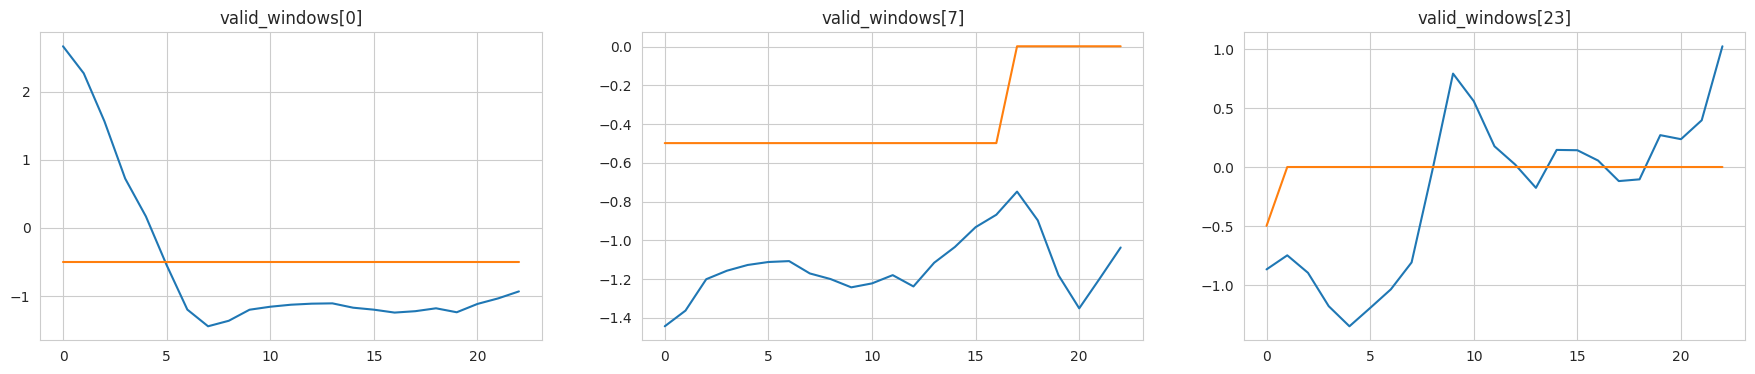

In [ ]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

LSTM Autoencoder model

In [ ]:
input_length = window_length
input_dim = 2
hidden_dim = 12
batch_size = 48 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 100

In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
np.random.seed(23)

In [ ]:
from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers import LSTM, GRU, TimeDistributed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.1))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(x_train.shape[2])))

from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               67072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 23, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 23, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 23, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 23, 2)            258       
 tributed)                                            

In [ ]:
checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
tbCallBack = TensorBoard(log_dir='./lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid),
                callbacks=[checkpointer, earlystopper, tbCallBack, ], verbose=0).history


Epoch 1: val_loss improved from inf to 0.16199, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 2: val_loss improved from 0.16199 to 0.09229, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 3: val_loss improved from 0.09229 to 0.05969, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 4: val_loss improved from 0.05969 to 0.04689, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 5: val_loss improved from 0.04689 to 0.04083, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 6: val_loss improved from 0.04083 to 0.03350, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 7: val_loss improved from 0.03350 to 0.02981, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 8: val_loss improved from 0.02981 to 0.02841, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 9: val_loss did not improve from 0.02841

Epoch 10: val_loss improved from 0.02841 to 0.02641, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 11: val_loss

In [ ]:
pred_y_valid = model.predict(x_valid)[:, :, 0]

183/183 [==============================] - 1s 3ms/step


Visualize the reconstruction on the validation set (select random sets)

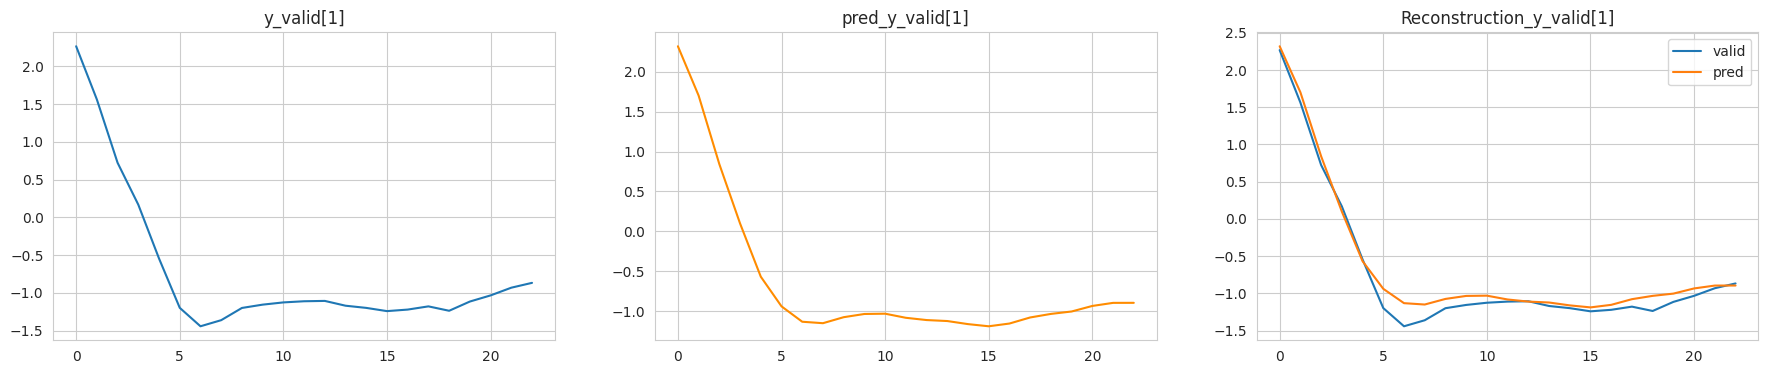

In [ ]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(y_valid[1])
plt.title('y_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_y_valid[1], color='darkorange')
plt.title('pred_y_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(y_valid[1], label='valid')
plt.plot(pred_y_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_y_valid[1]')
plt.grid(True)
plt.show();

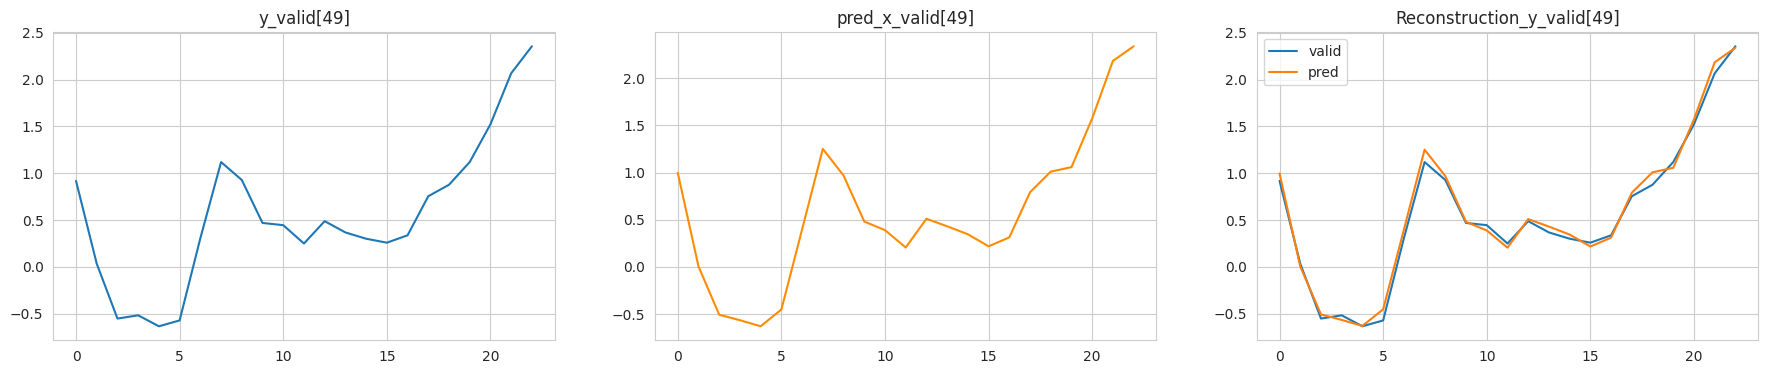

In [ ]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(y_valid[49])
plt.title('y_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_y_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(y_valid[49], label='valid')
plt.plot(pred_y_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_y_valid[49]')
plt.grid(True)
plt.show();

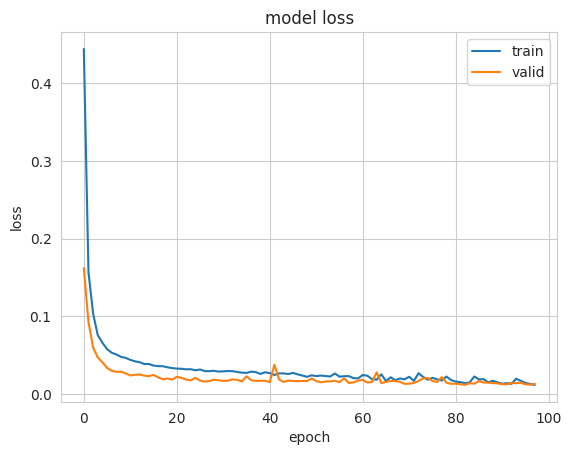

In [ ]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

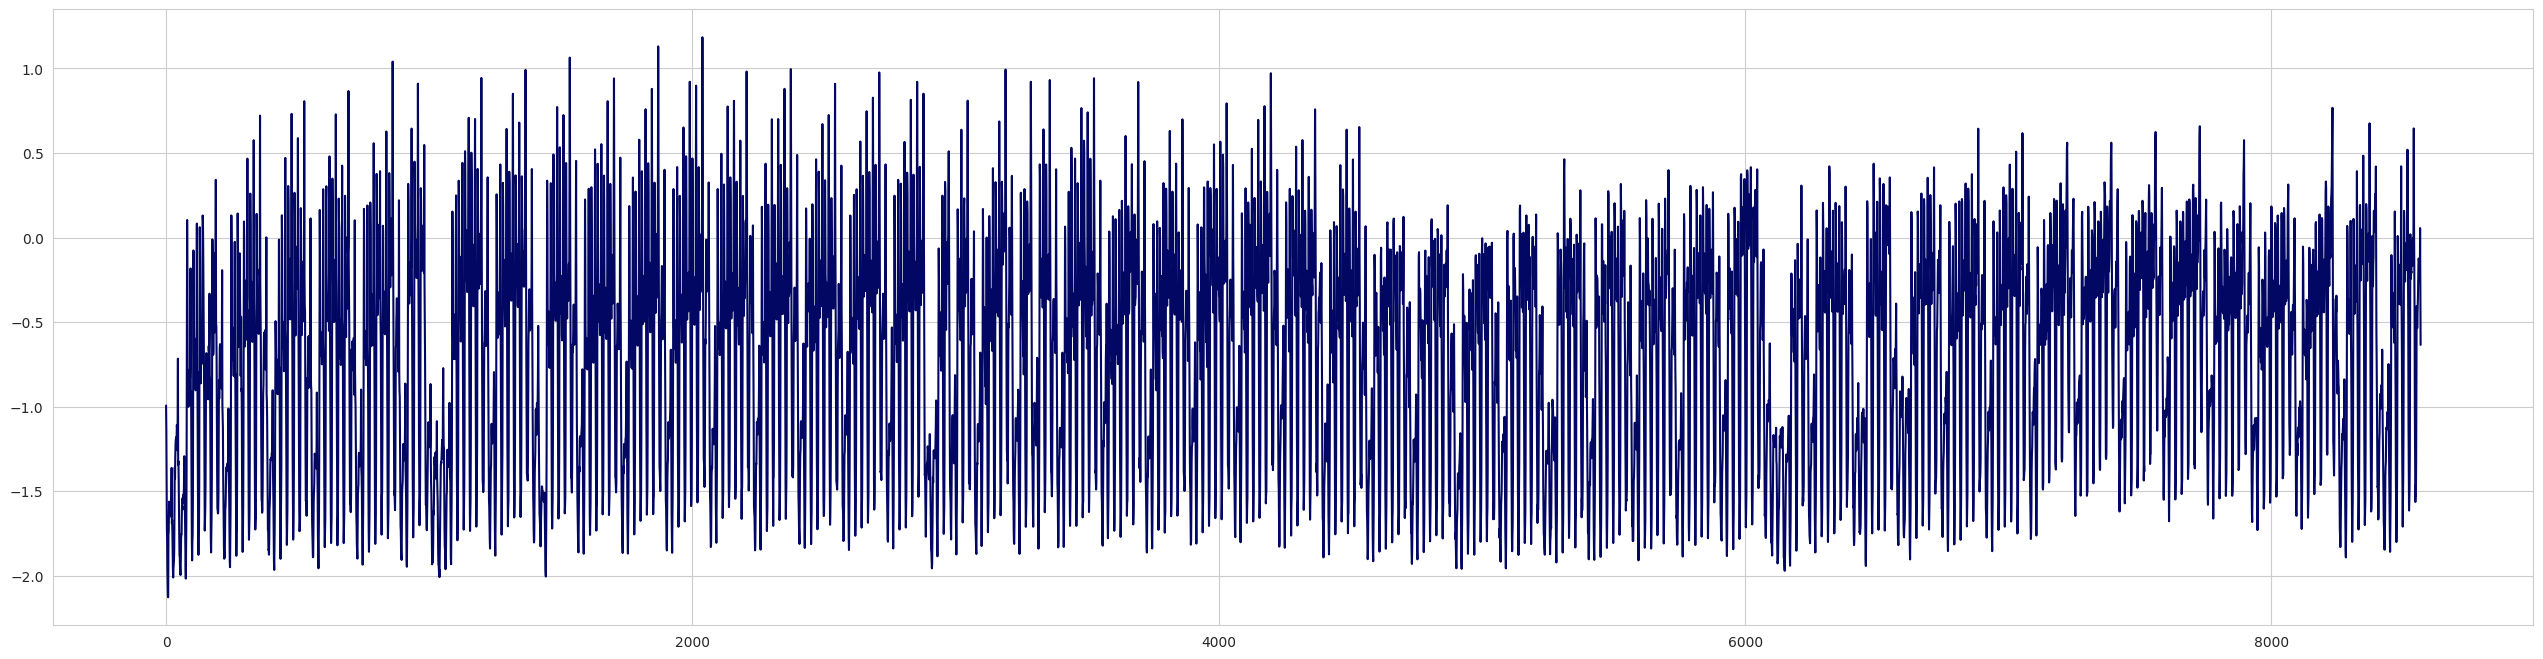

In [ ]:
# Set seaborn style to whitegrid
sns.set_style('whitegrid')

# Plotting the time series data
fig, ax = plt.subplots(figsize=(32, 8))
plt.plot(taxi_test[:,0], color='#030764')
plt.grid(True)

test sequences

In [ ]:
test_windows = []

for window_start in range(0, len(taxi_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(taxi_test[window_range])
    #is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    #contain_outliers.append(is_outlier)
    test_windows.append(window)

x_test = np.array(test_windows)
x_test.shape

(8546, 23, 2)

In [ ]:
y_test = np.array(test_windows)
y_test = y_test[:, :, 0].reshape(-1, x_test.shape[1], 1)

In [ ]:
pred_y_test = model.predict(x_test)[:, :, 0]

268/268 [==============================] - 1s 3ms/step


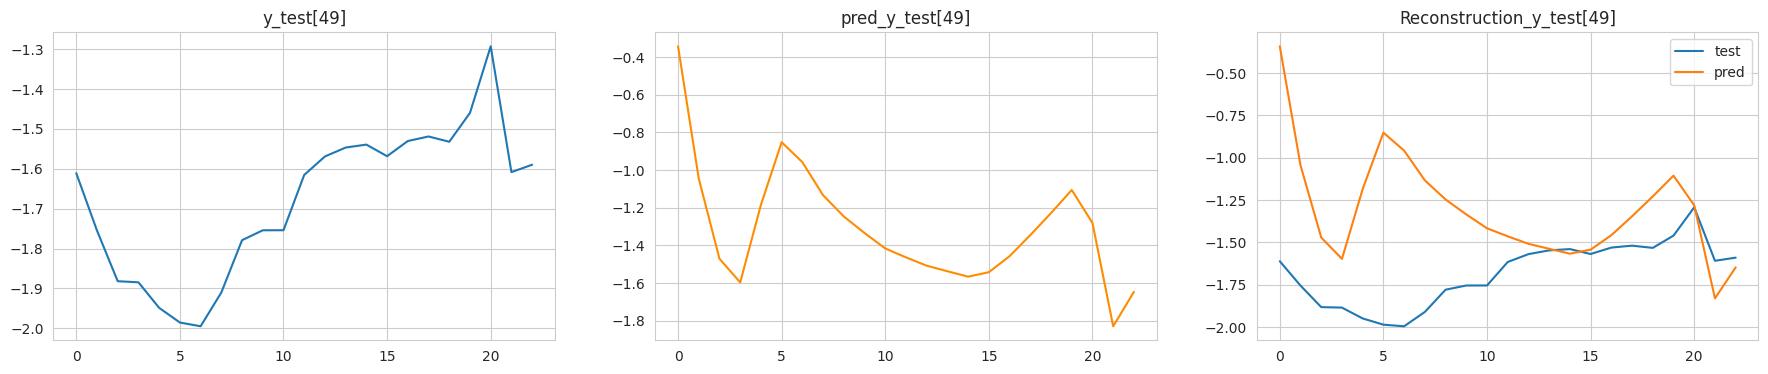

In [ ]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(y_test[49])
plt.title('y_test[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_y_test[49], color='darkorange')
plt.title('pred_y_test[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(y_test[49], label='test')
plt.plot(pred_y_test[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_y_test[49]')
plt.grid(True)
plt.show();

distribution of Reconstruction Errors on Validation and Test Set

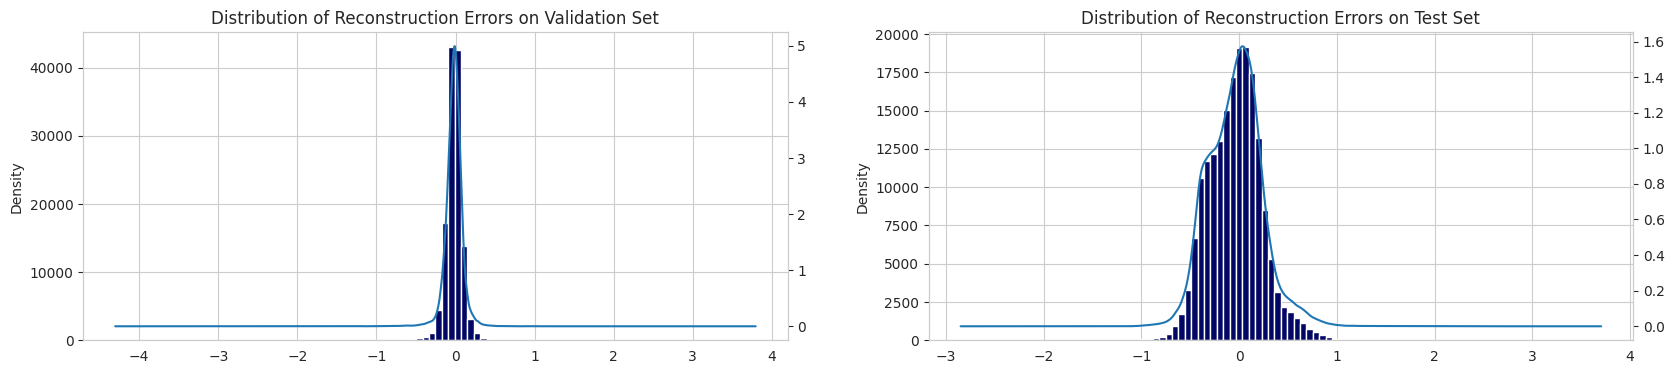

In [ ]:
all_errors_valid = pd.Series(np.squeeze(x_valid[:,1:,0] - pred_y_valid[:,1:]).flatten())
all_errors_test = pd.Series(np.squeeze((x_test)[:,1:,0] - pred_y_test[:,1:]).flatten())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
all_errors_valid.plot.hist(bins=50, ax=ax[0], color='#030764')
all_errors_valid.plot.kde(secondary_y=True, ax=ax[0])
ax[0].set_title('Distribution of Reconstruction Errors on Validation Set')
all_errors_test.plot.hist(bins=50, ax=ax[1], color='#030764')
all_errors_test.plot.kde(secondary_y=True, ax=ax[1])
ax[1].set_title('Distribution of Reconstruction Errors on Test Set');

Approach 2: Rank all Test windows by the sum of their absolute values of the Reconstruction Errors

In [ ]:
errors_test_per_window = np.squeeze(x_test[:,1:,0] - pred_y_test[:,1:])
errors_test_per_window

# reconstruction errors in test set in window 0
errors_test_per_window[0]

# calculate the sum of absolute reconstruction errors for window[0]
sum_abs_errors_window_0 = np.sum(np.abs(errors_test_per_window[0]))
sum_abs_errors_window_0

7.180906576779494

calculate the sum of absolute values of recontruction errors in each window

array([1426,   12,   13,   43, 1427,   11,   14, 1435, 1434, 1022, 1021,
       1425, 1433, 1023, 1020,   42,   17, 5340,   18,   44])

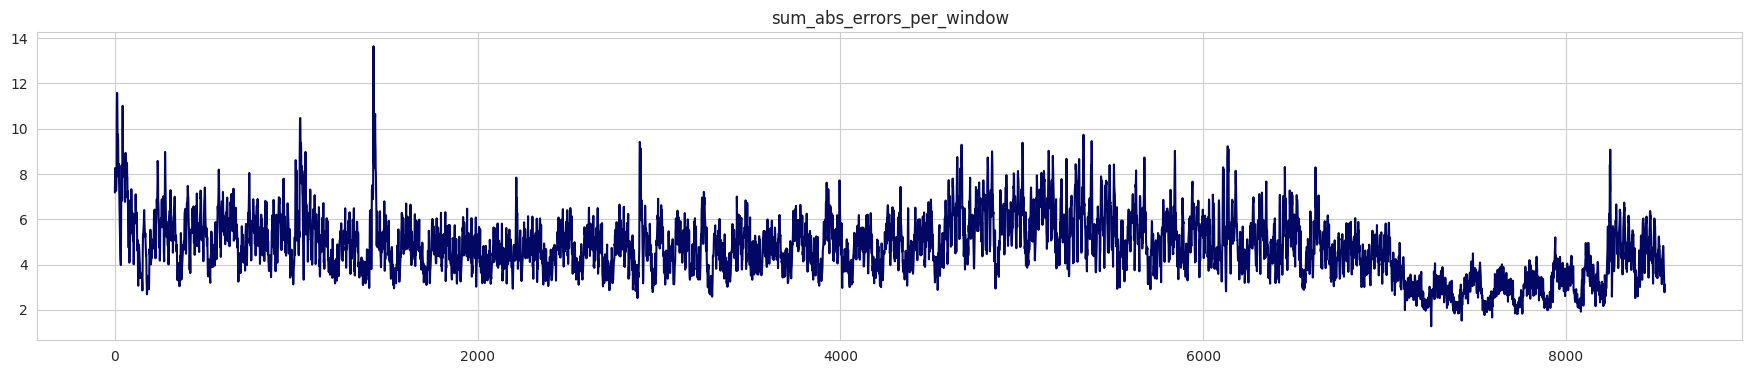

In [ ]:
def sum_abs_errors_window(errors_in_window):
    return np.sum(np.abs(errors_in_window))

sum_abs_errors_per_window = pd.Series([sum_abs_errors_window(errors_in_window) for errors_in_window in errors_test_per_window])
#sum_abs_errors_per_window[0]

plt.figure(figsize=(22, 4))
plt.plot(sum_abs_errors_per_window, color='#030764')
plt.title('sum_abs_errors_per_window')
plt.grid(True, which='both');

# Top anomalous windows ranked sum of the reconstruction errors in descending order
# we introduced anomalies in test windows 201 & 422
sum_abs_errors_per_window.nlargest(20)

pred_outlier_indices = sum_abs_errors_per_window.nlargest(20).index.values
pred_outlier_indices

In [ ]:
sum_abs_errors_per_window
#sum_abs_errors_per_window.to_csv('seocho_errors_2020.csv', index=True)

0       7.180907
1       7.917613
2       8.265212
3       8.162381
4       7.862623
          ...   
8541    3.453977
8542    3.014636
8543    2.778051
8544    2.857469
8545    3.117957
Length: 8546, dtype: float64

sort the windows by the highest absolute value of reconstruction errors

In [ ]:
pred_outlier_indices = pred_outlier_indices[~np.isin(pred_outlier_indices, [1421])]

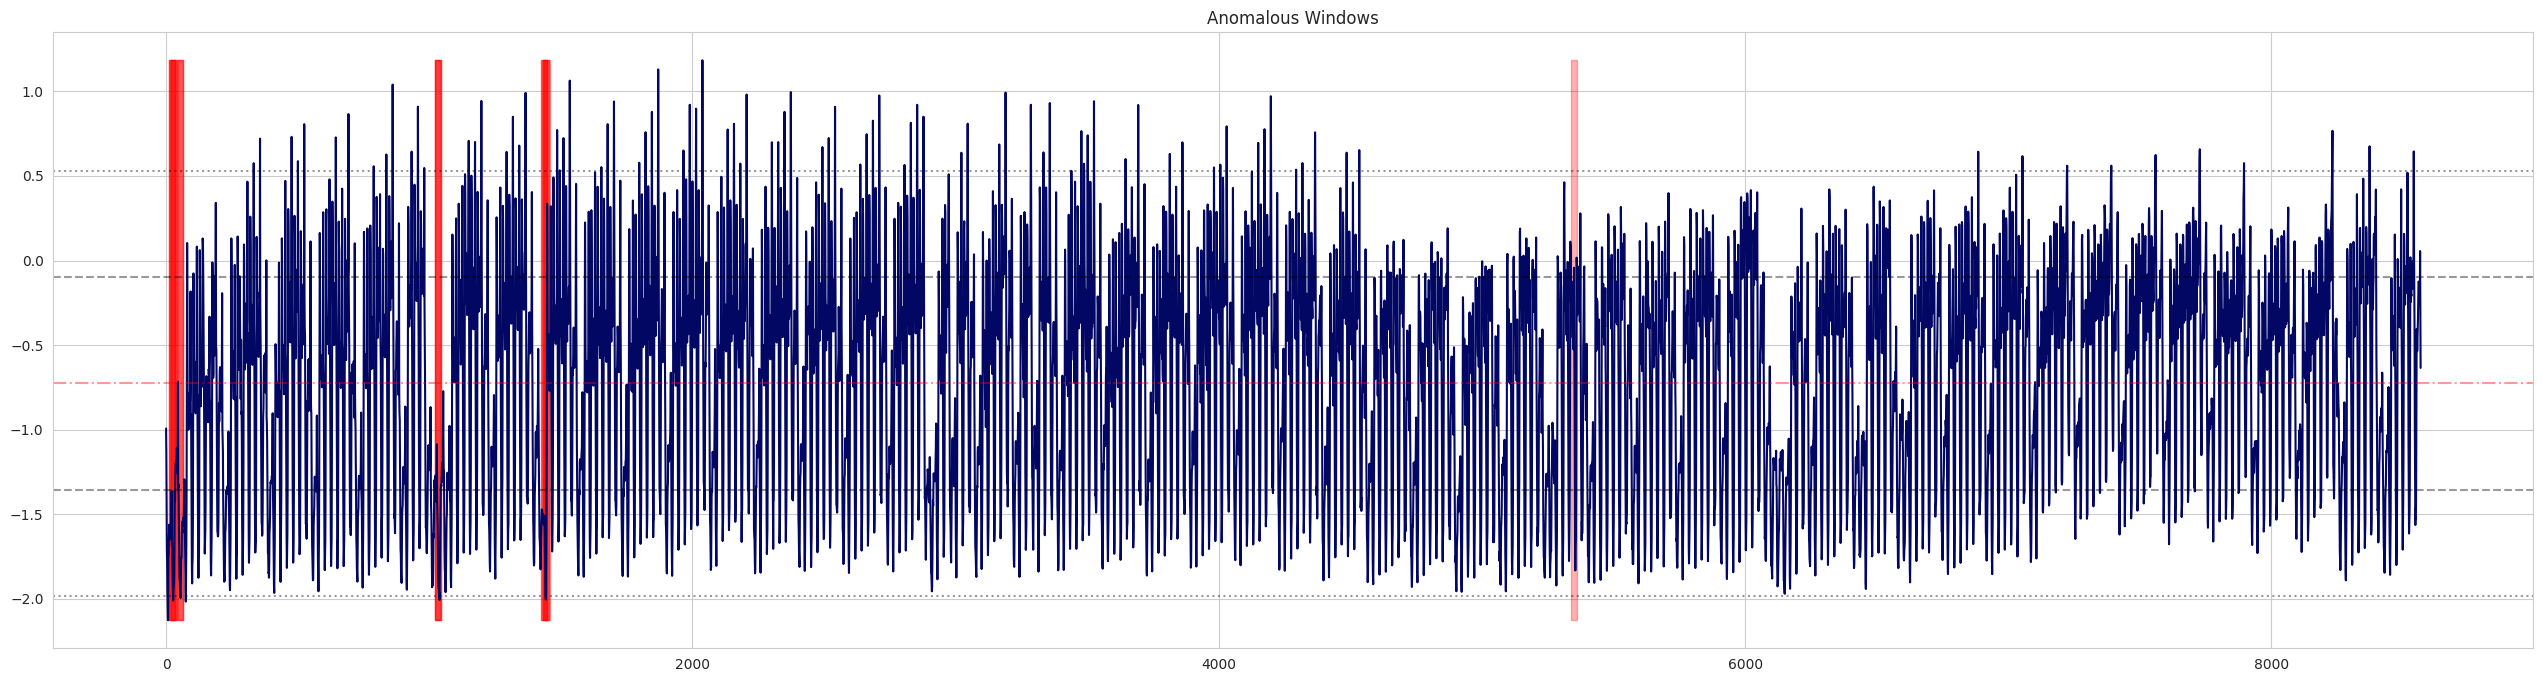

In [ ]:
#taxi_test_values = taxi_test[['taxi_count']].values

plt.figure(figsize=(32, 8))
plt.plot(taxi_test[:,0], color='#030764')
plt.axhline(y=taxi_test[:,0].mean(), color='r', linestyle='-.', alpha=0.4) # the  horizontal line for mean
plt.axhline(y=taxi_test[:,0].mean() + taxi_test[:,0].std(), color='k', linestyle='--', alpha=0.4) # mean + std_dev
plt.axhline(y=taxi_test[:,0].mean() + 2 * taxi_test[:,0].std(), color='k', linestyle=':', alpha=0.4) # mean + 2 * std_dev
plt.axhline(y=taxi_test[:,0].mean() - 2 * taxi_test[:,0].std(), color='k', linestyle=':', alpha=0.4) # mean - 2 * std_dev
plt.axhline(y=taxi_test[:,0].mean() - taxi_test[:,0].std(), color='k', linestyle='--', alpha=0.4) # mean - std_dev
for w_index in pred_outlier_indices:
    plt.fill_betweenx((taxi_test[:,0].min(), taxi_test[:,0].max()), w_index, w_index + window_length - 1, alpha=0.3, color='red')
plt.title('Anomalous Windows')
plt.grid(True);

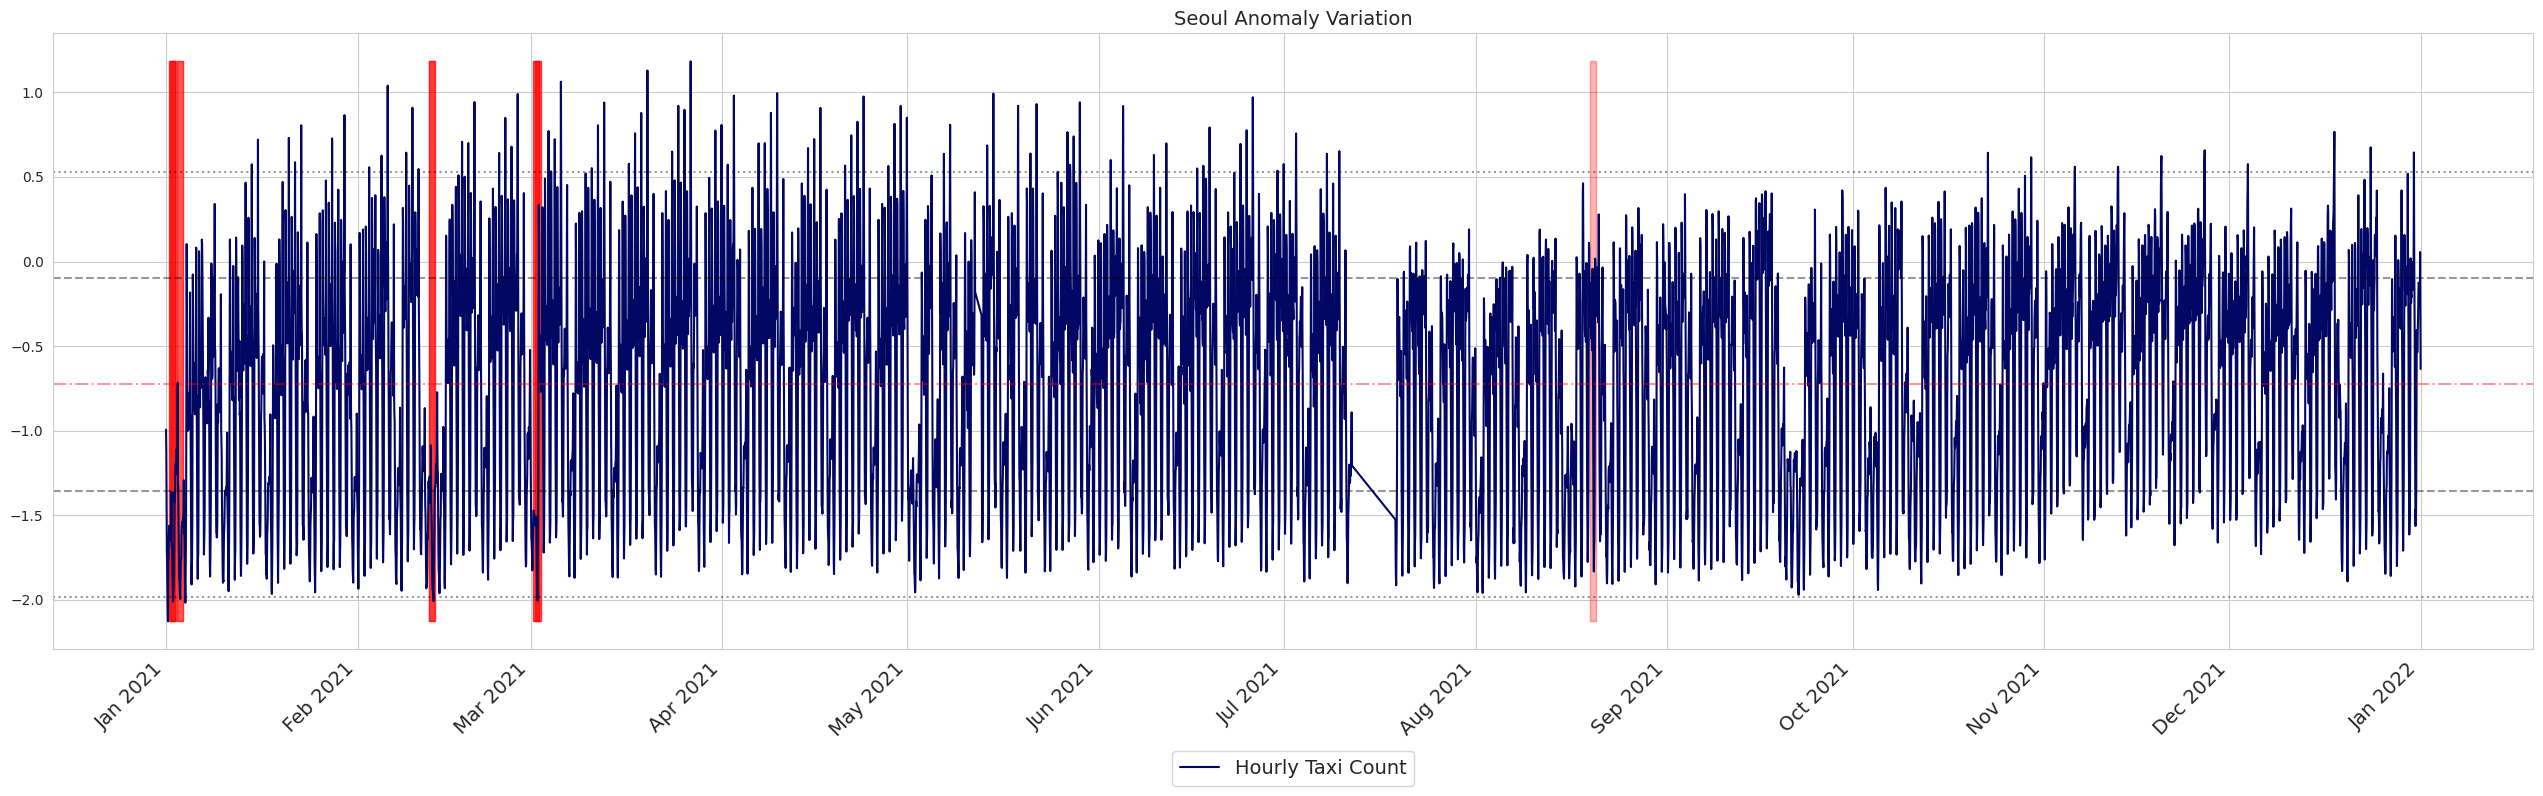

In [ ]:
test_data = data.loc['2021-01-01': '2021-12-31'].copy() # Make a copy of the DataFrame
index_values = test_data.index
test_data['new_column'] = range(len(test_data))  # Add the new column to the copied DataFrame
#test_data.loc[:, 'new_column'] = range(len(test_data))

# Plotting the time series data
fig, ax = plt.subplots(figsize=(32, 8))
plt.plot(test_data.index, taxi_test[:,0], color='#030764', label='Hourly Taxi Count')

# Formatting the x-axis to display monthly labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right', fontsize = 14)

plt.axhline(y=taxi_test[:,0].mean(), color='r', linestyle='-.', alpha=0.4) # the  horizontal line for mean
plt.axhline(y=taxi_test[:,0].mean() + taxi_test[:,0].std(), color='k', linestyle='--', alpha=0.4) # mean + std_dev
plt.axhline(y=taxi_test[:,0].mean() + 2 * taxi_test[:,0].std(), color='k', linestyle=':', alpha=0.4) # mean + 2 * std_dev
plt.axhline(y=taxi_test[:,0].mean() - 2 * taxi_test[:,0].std(), color='k', linestyle=':', alpha=0.4) # mean - 2 * std_dev
plt.axhline(y=taxi_test[:,0].mean() - taxi_test[:,0].std(), color='k', linestyle='--', alpha=0.4) # mean - std_dev
for w_index in pred_outlier_indices:
    start_date = test_data.index[w_index]
    end_date = test_data.index[w_index + window_length - 1]
    plt.fill_betweenx((taxi_test[:,0].min(), taxi_test[:,0].max()),
                      start_date, end_date, alpha=0.3, color='red')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize = 14)
plt.title('Seoul Anomaly Variation', fontsize = 14)
plt.grid(True);
#plt.show()

In [ ]:
relevant_hours = test_data[test_data['new_column'].isin(pred_outlier_indices)]
relevant_hours = relevant_hours.reset_index()
relevant_hours

,hour,taxi_count,day_of_week,new_column
0,2021-01-01 11:00:00,-1.620223,0.501096,11
1,2021-01-01 12:00:00,-1.561232,0.501096,12
2,2021-01-01 13:00:00,-1.611479,0.501096,13
3,2021-01-01 14:00:00,-1.601795,0.501096,14
4,2021-01-01 17:00:00,-1.583910,0.501096,17
5,2021-01-01 18:00:00,-1.614739,0.501096,18
6,2021-01-02 18:00:00,-1.137031,1.000671,42
7,2021-01-02 19:00:00,-1.257483,1.000671,43
8,2021-01-02 20:00:00,-1.079225,1.000671,44
9,2021-02-12 12:00:00,-1.296662,0.501096,1020


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming y_true contains the true values and y_pred contains the predicted values
mse = mean_squared_error(np.squeeze(y_test[:,:,0]), np.squeeze(pred_y_test))
rmse = np.sqrt(mse)

print(mse)
print(rmse)

0.07954027499028218
0.2820288548894992
